In [1]:
import matplotlib.pyplot as plt
import numpy as np
from post_processing_class import TensorTomographyReconstruction, SH_Reconstruction, EXPSIN_Reconstruction
from scipy.optimize import curve_fit
# plt.rcParams["axes.formatter.use_mathtext"] = True
# plt.rcParams["text.usetex"] = True  # Use Latex
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "serif",
#         "font.serif": ["Palatino"],
#     }
# )
plt.rcParams["svg.fonttype"] = "none"
%reload_ext autoreload
%autoreload 2

c:\Users\Bruker\anaconda3\envs\SAXSTT\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DEFAULT_FIGSIZE = (5.69, 3.9)
def plot_SH_aligned_distribution(
    AD,
    symbolic,
    dummy_values,
    slice,
    attribute,
    title="SH ",
    bins=100,
    save=False,
    save_name="SH_aligned_distribution_",
    std_c=2,
    DPI=100,
    size_fraction=0,
    shareaxis=True,
    morefigs=False,
):

    if attribute == "coeffs":
        keys = ["a0", "a2", "a4", "a6"]
        titles = keys
        rows, cols = 2, 2
        title += "Coefficients"
        save_name += "coeffs"
    elif attribute == "angles":
        keys = ["theta", "phi"]
        titles = [r"$\theta$", r"$\varphi$"]
        rows, cols = 1, 2
        title += "Orientation"
        save_name += "angles"

    slice1, slice2 = slice
    ind = np.arange(slice1, slice2)
    X, Y, Z = np.meshgrid(ind, ind, ind)

    if not size_fraction:
        cols_fraction = 1
        rows_fraction = 1
    else:
        cols_fraction = cols / size_fraction
        rows_fraction = rows / size_fraction

    size1, size2 = (
        cols_fraction * DEFAULT_FIGSIZE[0],
        rows_fraction * DEFAULT_FIGSIZE[1],
    )

    fig, axs = plt.subplots(rows, cols, figsize=(size1, size2), dpi=DPI)
    for i, (ax, key) in enumerate(zip(np.reshape(axs, -1), keys)):

        if attribute == "angles" and shareaxis:
            vmin, vmax = 0, np.pi
        elif attribute == "coeffs" and morefigs:
            vmin, vmax = (
                dummy_values[i] - std_c * dummy_values[i],
                dummy_values[i] + std_c * dummy_values[i],
            )
        else:
            vmin, vmax = find_vmin_vmax(AD[key][X, Y, Z], symbolic[key][X, Y, Z], std_c)

        AD_vals = AD[key][X, Y, Z].flatten()
        symbolic_vals = symbolic[key][X, Y, Z].flatten()

        ax.set_xlabel("Value")
        ax.set_ylabel("Count")
        ax.set_title(titles[i])

        AD_ax = ax.hist(
            AD_vals,
            label="AD",
            alpha=0.69,
            bins=bins,
            range=(vmin, vmax),
        )
        SYM_ax = ax.hist(
            symbolic_vals,
            label="SYM",
            alpha=0.69,
            bins=bins,
            range=(vmin, vmax),
        )

        ax.axvline(
            x=dummy_values[i],
            color="black",
            linestyle="--",
            alpha=0.69,
            label=f"Solution: {dummy_values[i]:.2f}",
        )

        AD_popt, cov1 = curve_fit(lorentzian, AD_ax[1][:-1], AD_ax[0])
        SYM_popt, cov2 = curve_fit(lorentzian, SYM_ax[1][:-1], SYM_ax[0])

        AD_fit = lorentzian(AD_ax[1], *AD_popt)
        SYM_fit = lorentzian(SYM_ax[1], *SYM_popt)

        AD_color = AD_ax[-1].patches[0].get_facecolor()
        ax.plot(
            AD_ax[1],
            AD_fit,
            color=AD_color,
            alpha=1,
            label="AD Lorentzian",  # $\mu$={:.2f}, $\sigma$={:.3f}".format(*AD_popt[1:]),
        )

        SYM_color = SYM_ax[-1].patches[0].get_facecolor()
        ax.plot(
            SYM_ax[1],
            SYM_fit,
            color=SYM_color,
            alpha=1,
            label="SYM Lorentzian",  # $\mu$={:.2f}, $\sigma$={:.3f}".format(*SYM_popt[1:]),
        )
        handles, labels = ax.get_legend_handles_labels()
        sol_handle = handles[2]
        sol_label = labels[2]
        ax.legend([sol_handle], [sol_label], loc="upper left")
    fig.suptitle(title)

    bbox_handles = [handles[i] for i in [0, 1, 3, 4]]
    bbox_labels = [labels[i] for i in [0, 1, 3, 4]]

    fig.legend(
        bbox_handles,
        bbox_labels,
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.4 / size2),
    )

    if save:
        plt.savefig(r"../Plotting/thesis_plots/" + save_name + ".svg")
    plt.show()
    return

def find_vmin_vmax(AD, symbolic, std_c):
    """
    Determines lower and upper bounds for plots given input data.
    Gives much space on left for legend
    """
    val1_lower = np.mean(AD) - 1.5 * std_c * np.std(AD)
    val2_lower = np.mean(symbolic) - 1.5 * std_c * np.std(symbolic)

    val1_upper = np.mean(AD) + std_c * np.std(AD)
    val2_upper = np.mean(symbolic) + std_c * np.std(symbolic)

    vmin = min(val1_lower, val2_lower)
    vmax = max(val1_upper, val2_upper)
    return vmin, vmax
    
def lorentzian(x, A, mu, gamma):
    return A / (np.pi * gamma) * gamma**2 / ((x - mu) ** 2 + gamma**2)

In [3]:
Dummy_path = r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\XRD_CT\Data Sets\Dummy_periodic_filter1_27cube_8off_0align.mat"
Dummy_1f27c8o = SH_Reconstruction(Dummy_path, dataset=True)
symbolic_path = r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\XRD_CT\Results\thesis_res\result_Dummy_periodic_filter1_27cube_8off_0align_q17-40_all_again_symbolic.mat"
symbolic_1f27c8o = SH_Reconstruction(symbolic_path, dataset=False)
AD_path = r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\XRD_CT\Results\thesis_res\result_Dummy_periodic_filter1_27cube_8off_0align_q17-40_all_again_AD_python.mat"
AD_1f27c8o = SH_Reconstruction(AD_path, dataset=False)

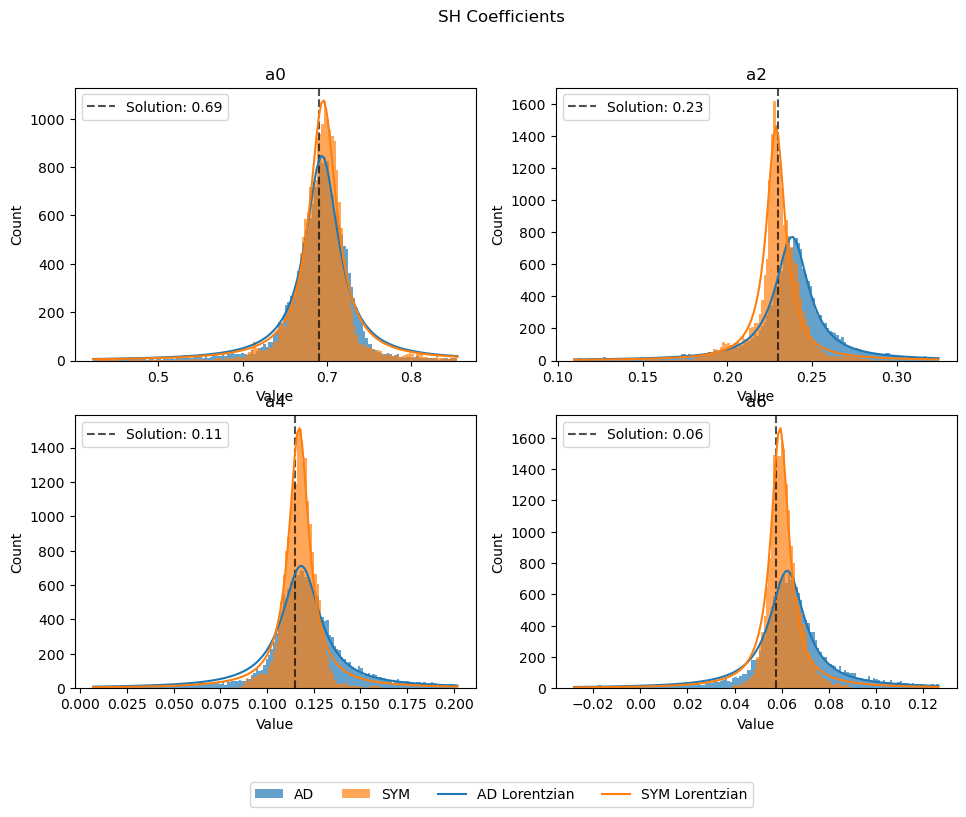

In [4]:
plot_SH_aligned_distribution(
    AD_1f27c8o,
    symbolic_1f27c8o,
    Dummy_1f27c8o.params[:,0,0,0],
    Dummy_1f27c8o.slice,
    "coeffs",
    title="SH ",
    bins=150,
    save=True,
    save_name="another_svg_test",
    std_c=2,
    DPI = 100,
    morefigs = False,
    size_fraction = 1
)